PARTE 0: Creación del dataframe con las publicaciones en el market place

Importo las librerias necesarias

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import json
from datetime import date


Le pego a la API de Mercado Libre

En primer lugar, creo un df con las categorias en el marketplace y su respectivo código

In [471]:
url_categorias = """https://api.mercadolibre.com/sites/MLA/categories""" #Defino la consulta
df_categorias = pd.read_json(url_categorias) #Creo el df
df_categorias.columns=['cd_categoria','tx_categoria'] #Defino las columnas

En segundo lugar, para cada categoria busco más información. Para este ejercicio, solo tomaré el total de publicaciones dentro de cada categoria y las publicaciones existentes

In [4]:
#Creo un campo vacio con el recuento de publicaciones por categoria en el df anterior
df_categorias['nu_publicaciones'] = float('NaN')

#Creo un df auxiliar con todas las publicaciones con descuento de cada categoria
df_publicaciones = pd.DataFrame()

El total de las publicaciones es demasiado grande para hacer un análisis exhaustivo. Opto por traerme las primeras 50 páginas de cada categoría (o el máximo de páginas en caso de que la categoría no llegue a 50 páginas)

In [ ]:
#Armo un loop que primero ponga el total de publicaciones bajo cada categoria en el df anterior, y luego inserte las publicaciones en df_publicaciones
for i in df_categorias.cd_categoria:
  url_categoria_especifica = """http://api.mercadolibre.com/sites/MLA/search?category="""+str(i)
  response = requests.get(url_categoria_especifica)
  json_data = json.loads(response.text)
  df_categorias.loc[df_categorias.cd_categoria==i,'nu_publicaciones'] = json_data['paging']['total']
  paginas = min(round(json_data['paging']['total']/50)+1,50)
  df = pd.DataFrame()
  for x in range(0,paginas):
    #print(i +' ' +str(df_categorias.loc[df_categorias.cd_categoria==i,].index.values[0]+1)+' de ' + str(df_categorias.shape[0]) + ' ' +str(100*round(x/paginas,2))+'%')
    url_explorativo = url_categoria_especifica+'&limit=50&search_type=scan'
    response_explorativo = requests.get(url_explorativo)
    json_data_explorativo = json.loads(response_explorativo.text)
    df_pagina = pd.DataFrame(json_data_explorativo['results'])
    df_pagina['cd_categoria'] = i
    df = pd.concat([df,df_pagina], axis=0)
    del(df_pagina)
  df_publicaciones = pd.concat([df_publicaciones,df], axis=0).reset_index(drop=True)
  del(url_categoria_especifica,response, json_data, df, paginas,url_explorativo,response_explorativo,json_data_explorativo )

In [6]:
#Por ultimo, creo un df consolidando las categorias con la informacion de los productos en descuento por categoria
df_data = df_categorias.merge(df_publicaciones, how='left',on='cd_categoria')

PARTE 1: Análisis Exploratorio

In [8]:
#Me quedo con las publicaciones con descuento
df_descuento = df_data.loc[df_data.original_price.isna()==False,].reset_index(drop=True)


In [9]:
#Descuento promedio por categoria
df_descuento['original_price'] = df_descuento['original_price'].astype('float') 
df_descuento['vl_descuento'] = df_descuento['original_price']-df_descuento['price']

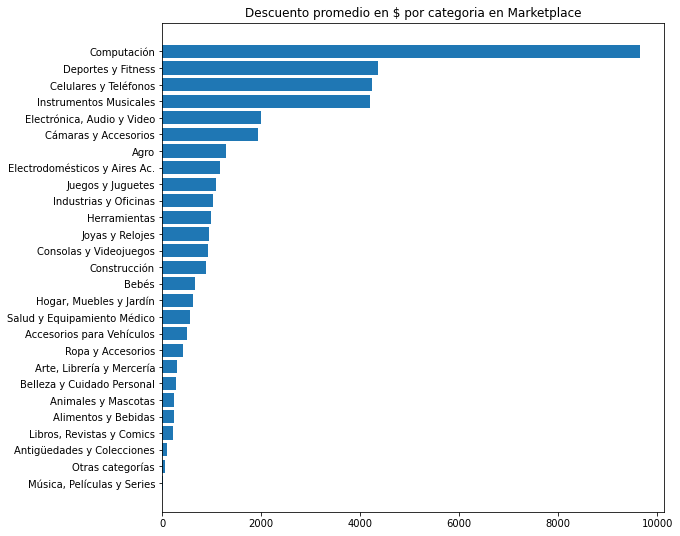

In [88]:
ds = df_descuento.groupby('tx_categoria')['vl_descuento'].mean().reset_index()
ds.sort_values(by='vl_descuento', ascending=True, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(ds.tx_categoria, ds.vl_descuento)

ax.set_title('Descuento promedio en $ por categoria en Marketplace')
plt.show()

In [ ]:
#Vemos los precios promedio por categoria
df_descuento.groupby('tx_categoria')['price'].mean().sort_values(ascending=False)

Logicamente, si vemos descuento en $, los mayores descuentos van a estar en categorías dónde el precio promedio es mayor. Es por esto que un mejor enfoque es ver el descuento relativo.

In [12]:
df_descuento['pc_descuento'] = df_descuento['vl_descuento']/df_descuento['original_price']

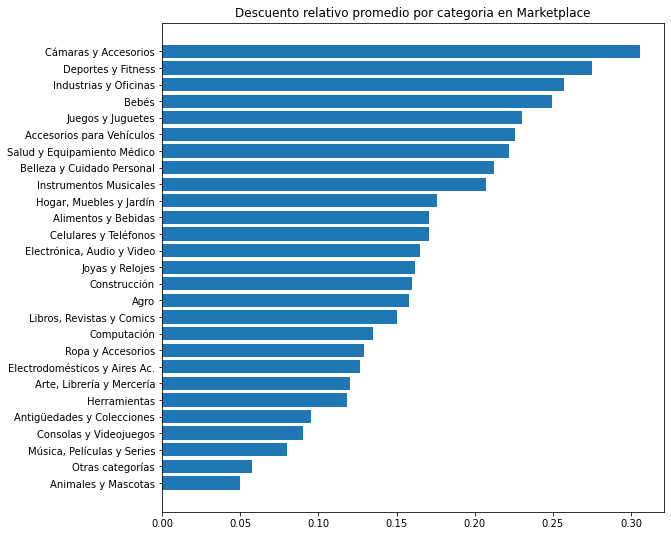

In [89]:
#Repito análisis con pc_descuento
ds = df_descuento.groupby('tx_categoria')['pc_descuento'].mean().reset_index()
ds.sort_values(by='pc_descuento', ascending=True, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(ds.tx_categoria, ds.pc_descuento)

ax.set_title('Descuento relativo promedio por categoria en Marketplace')
plt.show()

Al ver los descuentos en términos relativos, el orden cambia. Computación, que en $ era la categoría con mayores descuentos, ahora aparece en la parte baja del gráfico

Para tener una imagen más clara de cómo son los descuentos en las distintas categorías, nos resta ver cuántas publicaciones tienen descuento del total, y cómo se distribuyen estos descuentos. Calculamos el % de publicaciones con descuento y luego vemos la distribucion para las categorias con al menos 5% de publicaciones con descuento

In [ ]:
df_data['fl_descuento'] = 0 #Creo una marca de descuento en 0
df_data.loc[df_data.original_price.isna()==False,'fl_descuento'] = 1 #Le pongo =1 cuando tuvo descuento
ds = df_data.groupby('tx_categoria').agg({'nu_publicaciones':'max',
                                     'id':'count',
                                     'fl_descuento':'sum'
                                     }).reset_index()
ds.columns = ['tx_categoria','nu_publicaciones','nu_muestra','nu_muestra_descuento']
ds['pc_muestra_descuento'] = ds['nu_muestra_descuento']/ds['nu_muestra']
ds.sort_values(by='pc_muestra_descuento', ascending=False).head() #Vemos las categorías con más descuentos en términos relativos

Asumiendo que la muestra obtenida es representativa de la población, podemos tener un aproximado del número de publicaciones con descuento en cada una

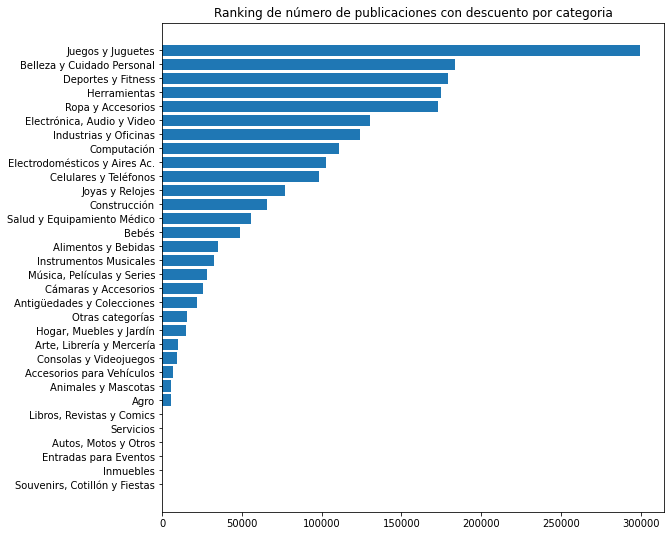

In [93]:
ds['nu_publicaciones_con_descuento'] = ds['nu_publicaciones']*ds['pc_muestra_descuento']
ds.sort_values(by='nu_publicaciones_con_descuento', ascending=True, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(ds.tx_categoria, ds.nu_publicaciones_con_descuento)

ax.set_title('Ranking de número de publicaciones con descuento por categoria')
plt.show()

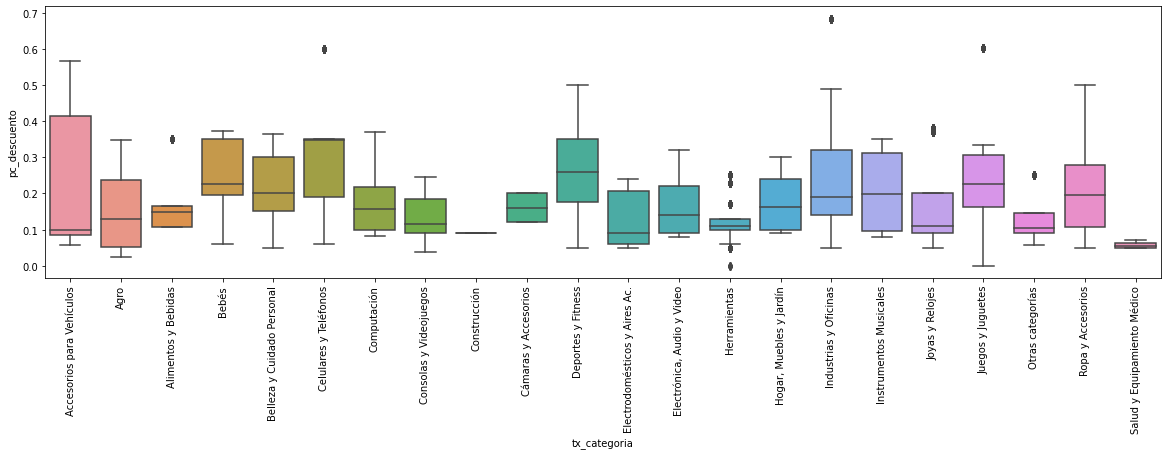

In [82]:
#Una alternativa a ver promedios, es ver las distribuciones, que nos dan una imagen más clara de los comportamiento dentro de cada categoria
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
ax = sns.boxplot(data=df_descuento.loc[df_descuento.tx_categoria.isin(list(ds.loc[ds.pc_muestra_descuento>=0.05,'tx_categoria'].values)),], 
                 y='pc_descuento', x='tx_categoria')

ax.set_xticks(np.arange(len(list(ds.loc[ds.pc_muestra_descuento>=0.05,'tx_categoria'].values))))
ax.set_xticklabels(list(ds.loc[ds.pc_muestra_descuento>=0.05,'tx_categoria'].values), rotation=90)
plt.show()

Al ver la distribución de los descuentos, podemos tener un panorama más claro de los descuentos que podemos llegar a encontrar en cada categoria. Algunos puntos interesantes son los descuentos en Celulares y Teléfonos, cuya mediana está por encima del 30%, y la amplia distribución de descuentos en Accesorios para Vehículos. Si bien la mediana de los descuentos está alrededor del 10%, podemos encontrar rebajas de más del 40%.
Por otro lado, hay categorías con descuentos muy acotados. Entre estos vemos a la categoría Construcción, Herramienas y Salud & Equipamiento Médico

Por último, veo si existe alguna relación entre la cantidad vendida o la cantidad disponible y el descuento relativo. Esto tmb me ayudará para la siguiente etapa del ejercicio

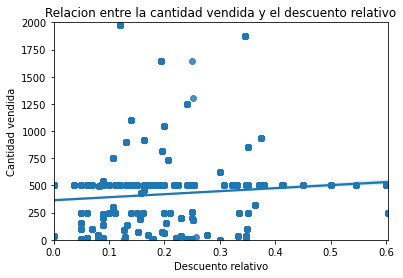

In [127]:
sns.regplot(x=df_descuento.loc[df_descuento.sold_quantity<np.percentile(df_descuento["sold_quantity"],95),'pc_descuento'],
            y=df_descuento.loc[df_descuento.sold_quantity<np.percentile(df_descuento["sold_quantity"],95),'sold_quantity'],
            )
plt.ylim(0,2000)
plt.title('Relacion entre la cantidad vendida y el descuento relativo')
plt.xlabel('Descuento relativo')
plt.ylabel('Cantidad vendida')
plt.show()

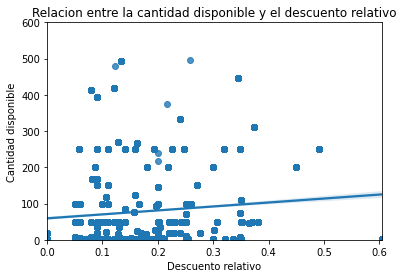

In [129]:
sns.regplot(x=df_descuento.loc[df_descuento.available_quantity<np.percentile(df_descuento["available_quantity"],95),'pc_descuento'],
            y=df_descuento.loc[df_descuento.available_quantity<np.percentile(df_descuento["available_quantity"],95),'available_quantity'],
            )
plt.ylim(0,600)
plt.title('Relacion entre la cantidad disponible y el descuento relativo')
plt.xlabel('Descuento relativo')
plt.ylabel('Cantidad disponible')
plt.show()

Las relaciones, para ambas variables no son muy claras. 

In [137]:
del(df_descuento)

PARTE 2. MODELO

Creo el dataset 

Reuno las variables que considero valiosas por si mismas o por ser fuente de info para nuevas variables

In [334]:
df = df_data[['id','cd_categoria','nu_publicaciones','seller','price','available_quantity','sold_quantity','accepts_mercadopago','address','shipping','original_price','official_store_id','tags','fl_descuento']]
df.rename(columns={'id':'cd_item'}, inplace=True)

In [335]:
#Transformo cd_categoria en dummies
df = df.merge(pd.get_dummies(df_data['cd_categoria'], drop_first=True, prefix='fl_categoria'), how='left', left_index=True, right_index=True)
df.drop(['cd_categoria'], axis=1, inplace=True)

In [336]:
#Renombro el campo publicaciones
df.rename(columns={'nu_publicaciones':'nu_publicaciones_categoria'}, inplace=True)

In [337]:
#Reuno info de los vendedores
df_vendedores=pd.DataFrame.from_dict(df['seller'].to_dict()).T
df_vendedores_info = pd.DataFrame(df_vendedores.seller_reputation.to_dict()).T
df_vendedores_info_transacciones= pd.DataFrame(df_vendedores_info.transactions.to_dict()).T
df_vendedores_info_transacciones_ratings = pd.DataFrame(df_vendedores_info_transacciones.ratings.to_dict()).T
df_vendedores_final = df_vendedores.merge(df_vendedores_info, how='left', left_index=True, right_index=True)
df_vendedores_final = df_vendedores_final.merge(df_vendedores_info_transacciones, how='left', left_index=True, right_index=True)
df_vendedores_final = df_vendedores_final.merge(df_vendedores_info_transacciones_ratings, how='left', left_index=True, right_index=True)
del(df_vendedores, df_vendedores_info, df_vendedores_info_transacciones, df_vendedores_info_transacciones_ratings)

In [338]:
#Me quedo con las columnas que me interesan y creo variables a partir de ellas
df_vendedores_final = df_vendedores_final[['registration_date','car_dealer','power_seller_status','level_id','total','canceled','completed','negative','positive','neutral']]
df_vendedores_final['nu_meses_antiguedad_vendedor'] =  (date.today()- pd.to_datetime(df_vendedores_final['registration_date'],format="%Y/%m/%d").dt.date) // np.timedelta64(1, 'M')
df_vendedores_final['fl_vendedor_car_dealer'] = 0
df_vendedores_final.loc[df_vendedores_final.car_dealer.isna()==True,'fl_vendedor_car_dealer'] = 1
df_vendedores_final = df_vendedores_final.merge(pd.get_dummies(df_vendedores_final['power_seller_status'],prefix='fl_vendedor_status'), how='left',left_index=True, right_index=True)
df_vendedores_final = df_vendedores_final.merge(pd.get_dummies(df_vendedores_final['level_id'],prefix='fl_vendedor_nivel'), how='left',left_index=True, right_index=True)
df_vendedores_final['pc_ventas_canceladas_vendedor'] = float('NaN')
df_vendedores_final.loc[df_vendedores_final.total>0,'pc_ventas_canceladas_vendedor'] = df_vendedores_final.loc[df_vendedores_final.total>0,'canceled']/df_vendedores_final.loc[df_vendedores_final.total>0,'total']
df_vendedores_final.rename(columns={'total':'nu_ventas_totales_vendedor',
                                  'negative':'pc_vendedor_comentarios_negativos',
                                  'positive':'pc_vendedor_comentarios_positivos'
                                  }, inplace=True)

In [339]:
df = df.merge(df_vendedores_final[['nu_ventas_totales_vendedor','pc_vendedor_comentarios_negativos',
                                   'pc_vendedor_comentarios_positivos','nu_meses_antiguedad_vendedor', 'fl_vendedor_car_dealer',
                                   'fl_vendedor_status_gold', 'fl_vendedor_status_platinum',
                                   'fl_vendedor_status_silver', 'fl_vendedor_nivel_3_yellow',
                                   'fl_vendedor_nivel_4_light_green', 'fl_vendedor_nivel_5_green',
                                   'pc_ventas_canceladas_vendedor']], how='left',left_index=True, right_index=True)

In [340]:
#Elmino la columna original con info del vendedor y el df auxiliar
df.drop(['seller'], axis=1, inplace=True)
del(df_vendedores_final)

In [341]:
#Renombro la columna de precio, cantidad disponible,cantidad vendida y precio original
df.rename(columns={'price':'vl_precio',
                   'available_quantity':'nu_cantidad_disponible',
                   'sold_quantity':'nu_cantidad_vendida',
                   'original_price':'vl_precio_original'
                   }, inplace=True)

In [342]:
#Creo una dummy si acepta mercadopago
df['fl_acepta_mp'] = 0
df.loc[df.accepts_mercadopago==True,'fl_acepta_mp']=1
df.drop(['accepts_mercadopago'], axis=1, inplace=True)

#Creo una dummy si tiene store oficial
df['fl_store_oficial'] = 0
df.loc[df.official_store_id.isna()==False,'fl_store_oficial']=1
df.drop(['official_store_id'], axis=1, inplace=True)

In [343]:
#Reuno info del domicilio
df_domicilio=pd.DataFrame.from_dict(df['address'].to_dict()).T
df = df.merge(pd.get_dummies(df_domicilio[['state_name']],prefix='fl_domicilio'), how='left', left_index=True, right_index=True)
df.drop(['address'], axis=1, inplace=True)
del(df_domicilio)

In [345]:
#Reuno info de la entrega
df_entrega=pd.DataFrame.from_dict(df['shipping'].to_dict()).T
df = df.merge(df_entrega[['free_shipping']], how='left', left_index=True, right_index=True)
df['fl_entrega_gratis'] = 0
df.loc[df.free_shipping==True,'fl_entrega_gratis']=1
df.drop(['shipping','free_shipping'], axis=1, inplace=True)
del(df_entrega)

In [356]:
#De los tags solo me quedo con el numero
df['nu_tags'] = 0
for i in range(0,len(df)):
  df.loc[df.index==i,'nu_tags'] = len(df['tags'][i])
df.drop(['tags'], axis=1, inplace=True)

Análisis del dataset

In [364]:
df.isna().sum().sort_values(ascending=False)

vl_precio_original                   69614
pc_ventas_canceladas_vendedor         2700
nu_tags                                  0
fl_categoria_MLA1540                     0
fl_categoria_MLA1430                     0
                                     ...  
pc_vendedor_comentarios_positivos        0
pc_vendedor_comentarios_negativos        0
nu_ventas_totales_vendedor               0
fl_categoria_MLA9304                     0
cd_item                                  0
Length: 71, dtype: int64

In [366]:
#Elimino vl_precio_original porque tiene muchos nulos
df.drop(['vl_precio_original'], axis=1, inplace=True)

Modelado

In [386]:
#Cambio el formato de las variables a float
for i in df.columns[1:]:
  df[i] = df[i].astype(float)

In [ ]:
#Creo lista de variables target y explicativas
variables = list(df.columns[1:]) #Tomo a partir de la primera porque cd_item es identificatoria
variables.remove('nu_cantidad_vendida') #La elimino porque es el target a predecir
target = ['nu_cantidad_vendida']

In [456]:
#Divido la poblacion entre train y desarrollo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[variables], df[target], test_size=0.25, random_state=123)


Para modelar opto por el XGBoost. Es un algorimo de árbol que tiene como puntos positivos que puede manejar nulos (como los que deje en pc_ventas_canceladas_vendedor), puede detectar relaciones no lineales y suele tener una muy buena performace

In [462]:
#Defino los parámetros
param = {'max_depth': 4,
         'eta': 0.1, 
         'gamma': 0.1,
         'refresh_leaf': 0,
         'tree_method': 'exact',
         'verbose': 1, 
         #'objective': 'binary:logistic', 
         'objective': 'reg:squarederror',  
         'booster':'gbtree',
         'nthread': 4,
         'eval_metric': 'logloss', 
         'lambda': 0.05,
         'n_estimators':100,
         'min_child_weight': 20
         }

In [388]:
#Cambio el formato de los datasets para adecuarles al formato pedido por xgboost
import xgboost as xgb
Xgb_train = xgb.DMatrix(X_train, label=y_train)
Xgb_test = xgb.DMatrix(X_test, label=y_test)

In [463]:
#Entreno el modelo
xgb_fit = xgb.train(param, Xgb_train, num_boost_round=500)

In [464]:
#Estimo sobre el dataset de testeo
predictions = xgb_fit.predict(xgb.DMatrix(X_test))

In [465]:
df_performance = y_test.copy()
df_performance['nu_cantidad_vendida_estimada'] = predictions


In [466]:
#Trunco a cero las estimaciones negativas
df_performance.loc[df_performance.nu_cantidad_vendida_estimada<0,'nu_cantidad_vendida_estimada'] = 0 

Veo la perfomance del modelo. Al ser un modelo de regresión, una buena medida del error es el error relativo. Usaré el valor absoluto ya que penalizo de igual forma si el eror es hacia arriba o hacia abajo

In [467]:
df_performance['vl_error_relativo'] = abs(df_performance['nu_cantidad_vendida_estimada']-df_performance['nu_cantidad_vendida'])/df_performance['nu_cantidad_vendida']
df_performance.loc[df_performance.vl_error_relativo!=np.inf,'vl_error_relativo'].mean() #Veo el error relativo promedio sacando los infinitos (que surgen al dividir por cero)

4.045121110963405

El error relativo obtenido en este modelo es grande. Se puede iterar cambiando los parámetros del xgboost apoyándote en randomserach o cross validation, creando nuevos features y probando con nuevos algoritmos

Veo diferencias de performance segun categoria

In [472]:
df_performance = df_performance.merge(df_data[['cd_categoria']], how='left', left_index=True,right_index=True)
df_performance = df_performance.merge(df_categorias[['cd_categoria','tx_categoria']], how='left',on='cd_categoria')

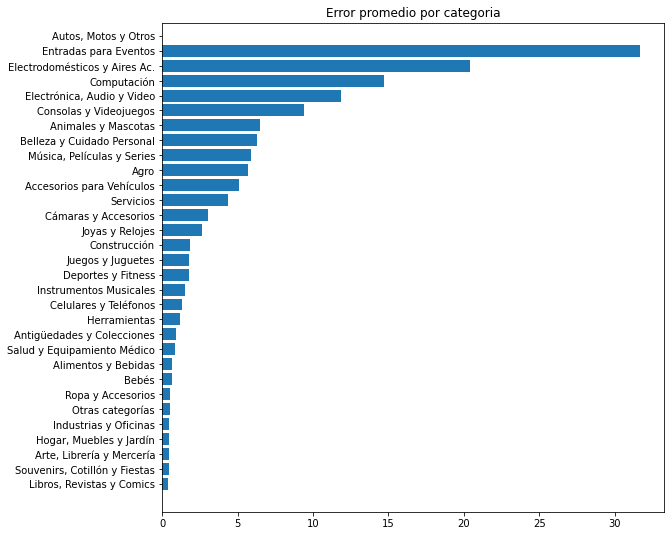

In [479]:
ds = df_performance.loc[df_performance.vl_error_relativo!=np.inf,].groupby('tx_categoria')['vl_error_relativo'].mean().reset_index()
ds.sort_values(by='vl_error_relativo', ascending=True, inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(ds.tx_categoria, ds.vl_error_relativo)

ax.set_title('Error promedio por categoria')
plt.show()